In [1]:
import numpy as numpy
import torch 
import sys
sys.path.append("../")
from model_dynamic_streaming_tensor import Streaming_Dynammic_Tensor_CP
import utils_streaming
import tqdm
import yaml
torch.random.manual_seed(300)

path = "./config_simulation_CP.yaml"
with open(path, "r") as f:
    config = yaml.safe_load(f)


data_file = '../data/simulation_CP_r1_0.05non-full.npy'


hyper_dict = utils_streaming.make_hyper_dict(config)
hyper_dict["R_U"] = 1

data_dict = utils_streaming.make_data_dict(hyper_dict,data_file)

INNER_ITER = hyper_dict["INNER_ITER"]
THRE = hyper_dict["THRE"]

model = Streaming_Dynammic_Tensor_CP(hyper_dict, data_dict)
model.reset()
# model.E_tau = 2


use device: cpu


In [2]:
for T_id in tqdm.tqdm(range(len(model.unique_train_time))):

    """ init_msg->filter_update->msg_approx->filter_update/post_update"""

    T = model.unique_train_time[T_id]
    model.track_envloved_objects(T_id)
    model.filter_predict(T)
    model.msg_llk_init()

    for inner_it in range(INNER_ITER):
        

        old_post = utils_streaming.get_post(model, T)
        flag = (inner_it == (INNER_ITER - 1))

        model.msg_U_m = []
        model.msg_U_V = []

        if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True: 
            for mode in range(model.nmods):
                model.msg_approx_U(T, mode)
                model.filter_update(T, mode, flag)

        else: 
            for mode in range(model.nmods):
                model.msg_approx_U(T, mode)

            for mode in range(model.nmods):
                model.filter_update(T, mode, flag)

        model.msg_approx_tau(T)
        model.post_update_tau(T)

        new_post = utils_streaming.get_post(model, T)

        relative_change = torch.square(new_post -
                                    old_post).sum() / old_post.norm()

        if flag:
            '''not converge till the MAX ITERATION'''
            pass
        elif relative_change < THRE:
            '''early converge'''

            if hyper_dict['CEP_UPDATE_INNNER_MODE'] == True: 
                for mode in range(model.nmods):
                    model.msg_approx_U(T, mode)
                    model.filter_update(T, mode, True)

            else: 
                for mode in range(model.nmods):
                    model.msg_approx_U(T, mode)

                for mode in range(model.nmods):
                    model.filter_update(T, mode, True)

            model.msg_approx_tau(T)
            model.post_update_tau(T)

            break


model.smooth()
model.get_post_U()

pred, test_result = model.model_test(model.te_ind, model.te_y,
                                    model.test_time_ind)

print(" test_error after smooth", test_result['rmse'])


100%|██████████| 500/500 [00:02<00:00, 208.71it/s]


 test_error after smooth tensor(0.0588, dtype=torch.float64)


In [3]:
print(model.post_U_m[0].shape)
print(model.post_U_v[0].shape)

torch.Size([2, 1, 1, 550])
torch.Size([2, 1, 1, 550])


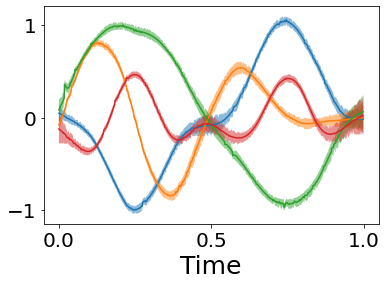

In [4]:
import matplotlib.pyplot as plt


v_coe = 1

plt.plot(model.time_uni,-model.post_U_m[0][0,0,0,:],label='$U_1^1$')

plt.fill_between(model.time_uni,-model.post_U_m[0][0,0,0,:] + v_coe*torch.sqrt(model.post_U_v[0][0,0,0,:]),-model.post_U_m[0][0,0,0,:]-v_coe*torch.sqrt(model.post_U_v[0][0,0,0,:]),alpha=0.5)


plt.plot(model.time_uni,-model.post_U_m[0][1,0,0,:],label='$U_2^1$')

plt.fill_between(model.time_uni,-model.post_U_m[0][1,0,0,:] + v_coe*torch.sqrt(model.post_U_v[0][1,0,0,:]),-model.post_U_m[0][1,0,0,:]-v_coe*torch.sqrt(model.post_U_v[0][1,0,0,:]),alpha=0.5)

plt.plot(model.time_uni,-model.post_U_m[1][0,0,0,:],label='$U_1^2$')

plt.fill_between(model.time_uni,-model.post_U_m[1][0,0,0,:] + v_coe* torch.sqrt(model.post_U_v[1][0,0,0,:]),-model.post_U_m[1][0,0,0,:]-v_coe*torch.sqrt(model.post_U_v[1][0,0,0,:]),alpha=0.5)

plt.plot(model.time_uni,-model.post_U_m[1][1,0,0,:],label='$U_2^2$')

plt.fill_between(model.time_uni,-model.post_U_m[1][1,0,0,:] + v_coe*torch.sqrt(model.post_U_v[1][1,0,0,:]),-model.post_U_m[1][1,0,0,:]-v_coe*torch.sqrt(model.post_U_v[1][1,0,0,:]),alpha=0.5)
# plt.legend()
plt.yticks([-1.0,0.0,1],fontsize=20)
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)
plt.savefig("figs/simu_pred.pdf", format="pdf", bbox_inches="tight")

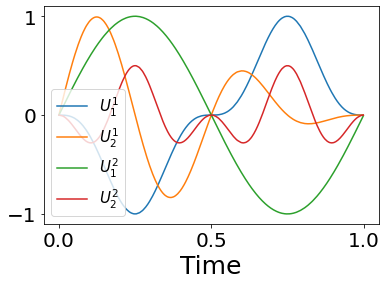

In [5]:
traj_ground = data_dict['traj_ground']
plt.plot(model.time_uni,traj_ground[0][0],label='$U_1^1$')
plt.plot(model.time_uni,traj_ground[0][1],label='$U_2^1$')
plt.plot(model.time_uni,traj_ground[1][0],label='$U_1^2$')
plt.plot(model.time_uni,traj_ground[1][1],label='$U_2^2$')

plt.legend(fontsize=15)
plt.yticks([-1.0,0.0,1],fontsize=20)
plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)
plt.savefig("figs/simu_true.pdf", format="pdf", bbox_inches="tight")

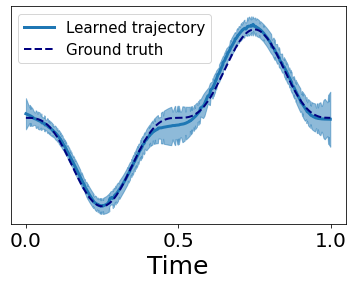

In [55]:
v_coe=2

plt.plot(model.time_uni,-model.post_U_m[0][0,0,0,:],'tab:blue',linewidth=3,label='Learned trajectory')

plt.fill_between(model.time_uni,-model.post_U_m[0][0,0,0,:] + v_coe*torch.sqrt(model.post_U_v[0][0,0,0,:]),-model.post_U_m[0][0,0,0,:]-v_coe*torch.sqrt(model.post_U_v[0][0,0,0,:]),alpha=0.5,color='tab:blue')
plt.plot(model.time_uni,traj_ground[0][0],'--',color='navy',linewidth=2,label='Ground truth')
plt.legend(fontsize=15)
# plt.yticks([-1.0,0.0,1],fontsize=20)
plt.yticks([],[])

plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)

plt.savefig("figs/simu_U11.pdf", format="pdf", bbox_inches="tight")

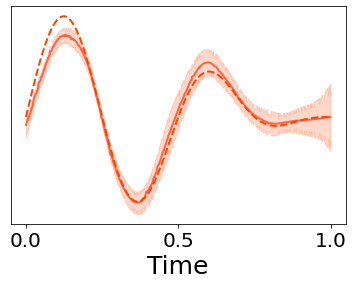

In [41]:
v_coe=2

plt.plot(model.time_uni,-model.post_U_m[0][1,0,0,:],'tomato',linewidth=2,label='learned trajectory')

plt.fill_between(model.time_uni,-model.post_U_m[0][1,0,0,:] + v_coe*torch.sqrt(model.post_U_v[0][1,0,0,:]),-model.post_U_m[0][1,0,0,:]-v_coe*torch.sqrt(model.post_U_v[0][1,0,0,:]),alpha=0.3,color='coral')
plt.plot(model.time_uni,traj_ground[0][1],'--',color='orangered',linewidth=2)
# plt.legend(fontsize=15)
# plt.yticks([-1.0,0.0,1],fontsize=20)
plt.yticks([],[])

plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)

plt.savefig("figs/simu_U12.pdf", format="pdf", bbox_inches="tight")

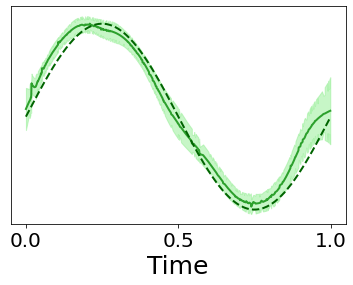

In [48]:
v_coe=2

plt.plot(model.time_uni,-model.post_U_m[1][0,0,0,:],'tab:green',linewidth=2,label='learned trajectory')

plt.fill_between(model.time_uni,-model.post_U_m[1][0,0,0,:] + v_coe*torch.sqrt(model.post_U_v[1][0,0,0,:]),-model.post_U_m[1][0,0,0,:]-v_coe*torch.sqrt(model.post_U_v[1][0,0,0,:]),alpha=0.5,color='lightgreen')
plt.plot(model.time_uni,traj_ground[1][0],'--',color='darkgreen',linewidth=2,label='Ground-Truth')
# plt.legend(fontsize=15)
# plt.yticks([-1.0,0.0,1],fontsize=20)
plt.yticks([],[])

plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)

plt.savefig("figs/simu_U21.pdf", format="pdf", bbox_inches="tight")

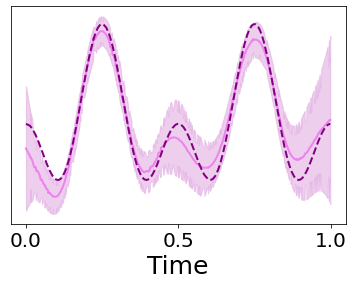

In [54]:
v_coe=2

plt.plot(model.time_uni,-model.post_U_m[1][1,0,0,:],'violet',linewidth=2,label='learned trajectory')

plt.fill_between(model.time_uni,-model.post_U_m[1][1,0,0,:] + v_coe*torch.sqrt(model.post_U_v[1][1,0,0,:]),-model.post_U_m[1][1,0,0,:]-v_coe*torch.sqrt(model.post_U_v[1][1,0,0,:]),alpha=0.5,color='plum')
plt.plot(model.time_uni,traj_ground[1][1],'--',color='purple',linewidth=2)
# plt.legend(fontsize=15)
# plt.yticks([-1.0,0.0,1],fontsize=20)
plt.yticks([],[])

plt.xticks([0.0,0.5,1.0],fontsize=20)
plt.xlabel('Time',fontsize=25)

plt.savefig("figs/simu_U22.pdf", format="pdf", bbox_inches="tight")